In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from utils import *

In [110]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [44]:
SEED = 1997

In [45]:
path = 'data/'
data = pd.read_csv(path + 'data_TiC_Onco.csv')
X = data[data.columns.difference(['id','excluido','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((391, 9), (391,))

In [46]:
X.head()

,Family,bmi,estadiGrup,rs2232698,rs4524,rs5985,rs6025,tipusTumor_HR,tipusTumor_VHR
0,0,1,1,0,1,1,0,0,0
1,0,0,0,0,1,0,0,0,1
2,0,0,1,0,2,0,0,1,0
3,0,0,1,0,2,0,0,0,0
4,0,1,1,0,2,0,0,0,0


In [47]:
y.value_counts() 

0    318
1     73
Name: VTE, dtype: int64

### Baseline model (Logistic Regression)

In [48]:
lr = LogisticRegression(solver='liblinear', random_state=SEED)

In [49]:
test_model_bootstrap(lr, X, y)

,score,mean,95% CI
0,AUC,0.75,"(0.68,0.81)"
1,accuracy,0.75,"(0.72,0.78)"
2,sensitivity,0.52,"(0.37,0.67)"
3,specificity,0.80,"(0.79,0.81)"
4,PPV,0.37,"(0.29,0.44)"
5,NPV,0.88,"(0.83,0.93)"


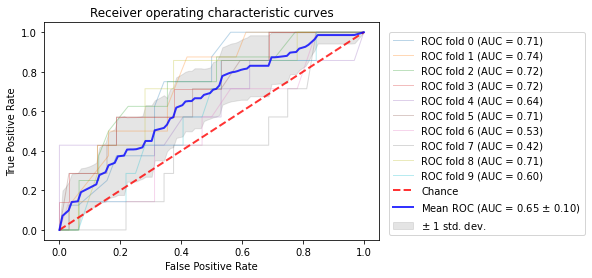

,score,mean,95% CI
0,AUC,0.65,"(0.45,0.85)"
1,accuracy,0.72,"(0.64,0.8)"
2,sensitivity,0.34,"(0,0.69)"
3,specificity,0.81,"(0.76,0.85)"
4,PPV,0.28,"(0.02,0.54)"
5,NPV,0.84,"(0.78,0.91)"


In [50]:
test_model(lr, X, y)

**AUC to beat = 0.65**

### Scaling data

same results...

In [58]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X)

### Tunning Logistic Regression

In [70]:
lr = Pipeline([('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0062505519252739694,
 'LR__class_weight': {1: 8},
 'LR__penalty': 'l2'}

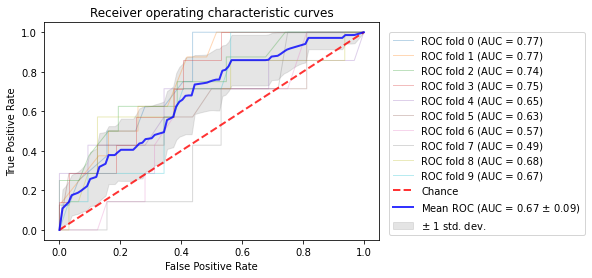

,score,mean,95% CI
0,AUC,0.67,"(0.5,0.85)"
1,accuracy,0.72,"(0.65,0.8)"
2,sensitivity,0.37,"(0.08,0.65)"
3,specificity,0.81,"(0.75,0.86)"
4,PPV,0.30,"(0.08,0.51)"
5,NPV,0.85,"(0.79,0.9)"


In [71]:
test_model(gs_lr.best_estimator_, X, y)

Adding MinMaxScaler...

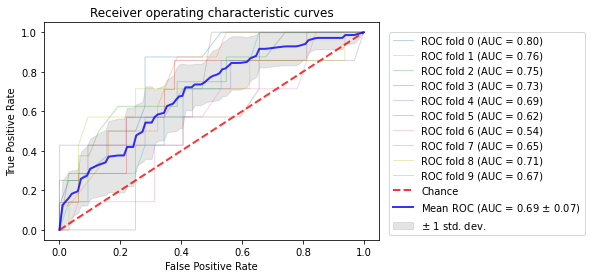

,score,mean,95% CI
0,AUC,0.69,"(0.55,0.84)"
1,accuracy,0.71,"(0.63,0.79)"
2,sensitivity,0.36,"(-0.0,0.73)"
3,specificity,0.79,"(0.72,0.85)"
4,PPV,0.27,"(0.01,0.53)"
5,NPV,0.85,"(0.78,0.91)"


In [72]:
lr = Pipeline([('scaler',MinMaxScaler()), ('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_
test_model(gs_lr.best_estimator_, X, y)

### LinearSVC

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions.

In [76]:
lin_svc = Pipeline([('LinearSVC',LinearSVC(random_state=1997, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.009102981779915217,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l1'}

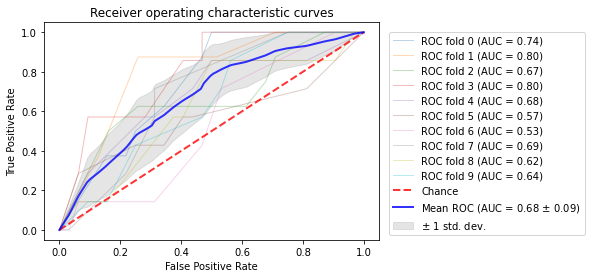

,score,mean,95% CI
0,AUC,0.67,"(0.5,0.85)"
1,accuracy,0.71,"(0.61,0.81)"
2,sensitivity,0.37,"(0.03,0.7)"
3,specificity,0.79,"(0.68,0.89)"
4,PPV,0.28,"(0.05,0.5)"
5,NPV,0.85,"(0.78,0.91)"


In [78]:
test_model(gs_lin_svc.best_estimator_, X, y)

In [79]:
lin_svc = Pipeline([('scaler',MinMaxScaler()), ('LinearSVC',LinearSVC(random_state=1997, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.00014563484775012445,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l2'}

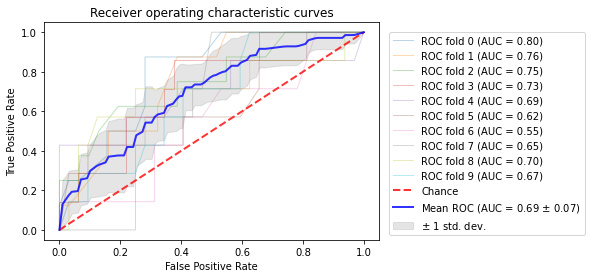

,score,mean,95% CI
0,AUC,0.69,"(0.55,0.83)"
1,accuracy,0.71,"(0.63,0.79)"
2,sensitivity,0.36,"(-0.0,0.73)"
3,specificity,0.79,"(0.72,0.85)"
4,PPV,0.27,"(0.01,0.53)"
5,NPV,0.85,"(0.78,0.91)"


In [80]:
test_model(gs_lin_svc.best_estimator_, X, y)

### KNN Classifier

In [108]:
knn = Pipeline([('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 163, 'KNN__p': 1, 'KNN__weights': 'uniform'}

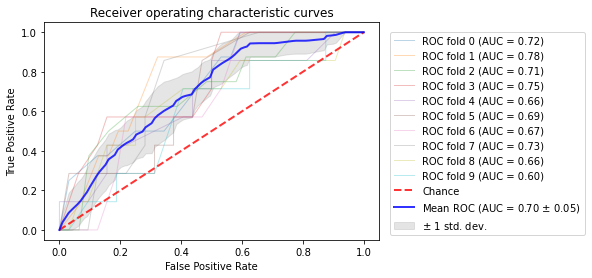

,score,mean,95% CI
0,AUC,0.70,"(0.6,0.8)"
1,accuracy,0.73,"(0.66,0.8)"
2,sensitivity,0.38,"(0.13,0.63)"
3,specificity,0.81,"(0.76,0.87)"
4,PPV,0.32,"(0.12,0.52)"
5,NPV,0.85,"(0.81,0.9)"


In [109]:
test_model(gs_knn.best_estimator_, X, y)

### Support Vector Machine

In [ ]:
svc = Pipeline([('SVC',SVC(probability=True, random_state=SEED))])

params_svc = {'SVC__C': np.logspace(-4, 4, 50), 'SVC__kernel': ['poly','rbf','sigmoid'], 'SVC__degree': [2,3,5,7],
          'SVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_svc = GridSearchCV(svc, params_svc, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_svc.fit(X,y)
gs_svc.best_params_

Fitting 10 folds for each of 4200 candidates, totalling 42000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 330 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 2730 tasks      | elapsed:   33.3s
[Parallel(n_jobs=2)]: Done 6730 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 12330 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 19530 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 28330 tasks      | elapsed:  6.5min
[Parallel(n_jobs=2)]: Done 31414 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done 34082 tasks      | elapsed: 10.9min
[Parallel(n_jobs=2)]: Done 36116 tasks      | elapsed: 15.1min
[Parallel(n_jobs=2)]: Done 38034 tasks      | elapsed: 28.1min
[Parallel(n_jobs=2)]: Done 39583 tasks      | elapsed: 69.7min


## Ensemble methods